In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import copy
import scrna._config

def prepare_data(data):

    result = {}

    for dataset_fullname, trials in data.items():
        # Clean up dataset name: e.g., 'Luecken2021\n(multiome)' -> 'multiome'
        name_dataset = dataset_fullname

        for trial in trials:
            for method, obs_dict in trial.items():
                if method == 'pca_X_pca':
                    continue
                    
                for obs, values in obs_dict.items():
                    if "pca_X_pca" not in trial or obs not in trial["pca_X_pca"]:
                        continue
                        
                    # Compute % improvement over PCA using the first value
                    i = 0
                    if obs == 'silhouette':
                        i = 0
                        
                    method_val = values[i]
                    pca_val = trial["pca_X_pca"][obs][i]

                    if pca_val == 0:
                        continue

                    delta = -100 * (method_val - pca_val) / pca_val

                    if obs == 'silhouette':
                        delta = - delta
                    # Init and collect
                    
                    result.setdefault(obs, {}).setdefault(name_dataset, {}).setdefault(method, []).append(delta)

    temp = copy.deepcopy(result)
    
    # Average over trials
    for obs in result:
        
        for dataset in result[obs]:
            for method in result[obs][dataset]:
                deltas = np.array(result[obs][dataset][method])
                result[obs][dataset][method] = [np.mean(deltas), np.std(deltas)]

    return result, temp

def merge_dicts(dict1, dict2):
    """
    Merge two nested dictionaries of the form:
    dict[observable][dataset][method] = [mean, std]
    """
    merged = copy.deepcopy(dict1)

    for observable, datasets in dict2.items():
        for dataset, methods in datasets.items():
            for method, values in methods.items():
                merged.setdefault(observable, {}).setdefault(dataset, {})[method] = values

    return merged

ngenes = 10000
flavor = 'seurat'
ntrials = 10

obs_all = json.load(open('figures/celltype_all_%s_%d_%d.json' % (flavor, ngenes, ntrials), 'r'))
res, samples = prepare_data(obs_all)

try:
    obs_dca = json.load(open('figures/celltype_dca_%s_%d_%d.json' % (flavor, ngenes, ntrials), 'r'))
    obs_scvi = json.load(open('figures/celltype_scvi_%s_%d_%d.json' % (flavor, ngenes, ntrials), 'r'))
    
    res_scvi, samples_scvi = prepare_data(obs_scvi)
    res_dca, samples_dca = prepare_data(obs_dca)

    res = merge_dicts(merge_dicts(res, res_scvi), res_dca)
    samples = merge_dicts(merge_dicts(samples, samples_scvi), samples_dca)
except:
    res, samples = prepare_data(obs_all)



In [95]:
import numpy as np
from collections import defaultdict

def rank_methods(res):
    per_dataset = defaultdict(lambda: defaultdict(list))

    for observable, dataset_dict in res.items():
        if observable == "silhouette":
            continue
        for dataset, method_dict in dataset_dict.items():
            for method, (mean, _) in method_dict.items():
                if method != "pca_X_pca":
                    per_dataset[dataset][method].append(mean)

    means = {
        dataset: {method: np.mean(vals) for method, vals in methods.items()}
        for dataset, methods in per_dataset.items()
    }
    
    sorted_means = {
        dataset: [method for method, _ in sorted(methods.items(), key=lambda kv: kv[1], reverse=False)]
        for dataset, methods in means.items()
    }

    return sorted_means

import numpy as np
from collections import defaultdict

def rank_methods_global(res, exclude=[]):
    # Accumulate all mean values per method across datasets and observables
    method_scores = defaultdict(list)
    print('excluding', exclude, 'from the ranking')
    for observable, dataset_dict in res.items():
        if observable == "silhouette":
            continue  # skip silhouette if it's not to be included
        for dataset, method_dict in dataset_dict.items():
            if dataset in exclude:
                continue
            for method, (mean, _) in method_dict.items():
                if method != "pca_X_pca":
                    method_scores[method].append(mean)

    # Compute average score across all datasets + observables
    mean_scores = {
        method: np.mean(scores) for method, scores in method_scores.items()
    }

    # Rank globally: lower is better (you can reverse if higher is better)
    global_ranking = [
        method for method, _ in sorted(mean_scores.items(), key=lambda kv: kv[1])
    ]

    return global_ranking


In [96]:
classi = {
    'diffusion': ['magic_X_pca'],
    'autoencoder': ['scvi_X_scVI', 'scvi_X_pca', 'dca_X_dca', 'dca_X_pca'],
    'pca': ['sclens_X_sclens', 'pca_biwhitened_X_pca', 'bipca_denoised_X_bipca', 'bipca_shrinked_X_bipca'],
    'spca' : ['sklearn_X_spca', 'amanpg_X_spca', 'sklearn_counts_X_spca', 'fista_gs_X_spca', 'sklearn_over_X_spca', 
              'fista_lowdin_X_spca'],
    'full': ['large_X_pca'],
}


# Define category colors
colors = {
    'diffusion': '#8da0cb',
    'autoencoder': '#e78ac3',
    'spca': '#65c2a5',
    'full': 'grey',
    'pca': '#fc8d62'
}

good_names = {
    'magic_X_pca': 'MAGIC (PCA)',
    'large_X_pca': 'full dataset (PCA)',
    'sklearn_X_spca': r'SPCA (sklearn)',
    'sklearn_over_X_spca': r'SPCA (sklearn $\gamma = 5 \gamma^*$)',
    'amanpg_X_spca': 'SPCA (amanpg)',
    'fista_gs_X_spca': 'SPCA (fista w/ GS)',
    'fista_lowdin_X_spca': 'SPCA (fista w/ Lowdin)',
    'scvi_X_pca': 'scVI (denoising w/ PCA)',
    'scvi_X_scVI': 'scVI (latent space)',
    'dca_X_dca': 'DCA (latent space)',
    'dca_X_pca': 'DCA (denoising w/ PCA)',
    'sclens_X_sclens': 'scLENS',
    'bipca_denoised_X_bipca': 'BiPCA (denoised)',
    'bipca_shrinked_X_bipca': 'BiPCA (shrinked)',
    'sklearn_counts_X_spca': 'SPCA (sklearn w/ counts)',
    'pca_biwhitened_X_pca': 'PCA (w/ biwhitening)',
}


excluding [] from the ranking
knn (n=10)


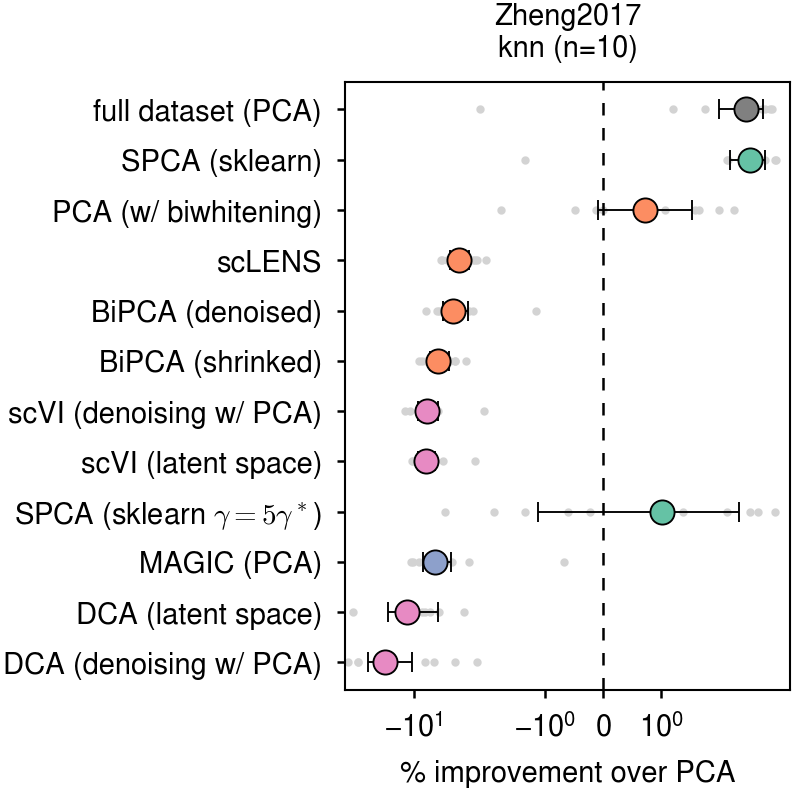

knn (n=10)


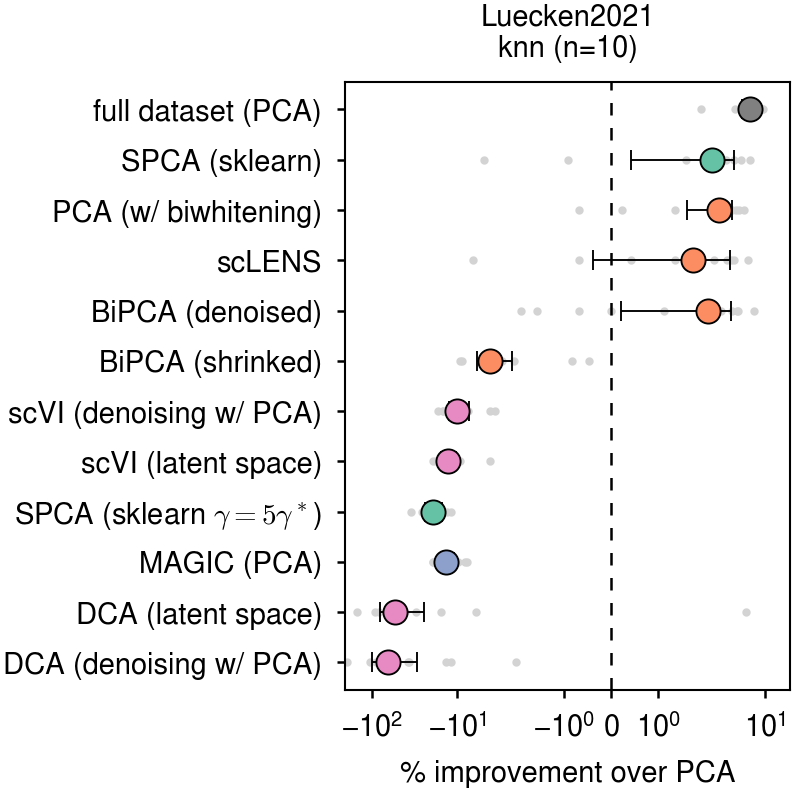

knn (n=10)


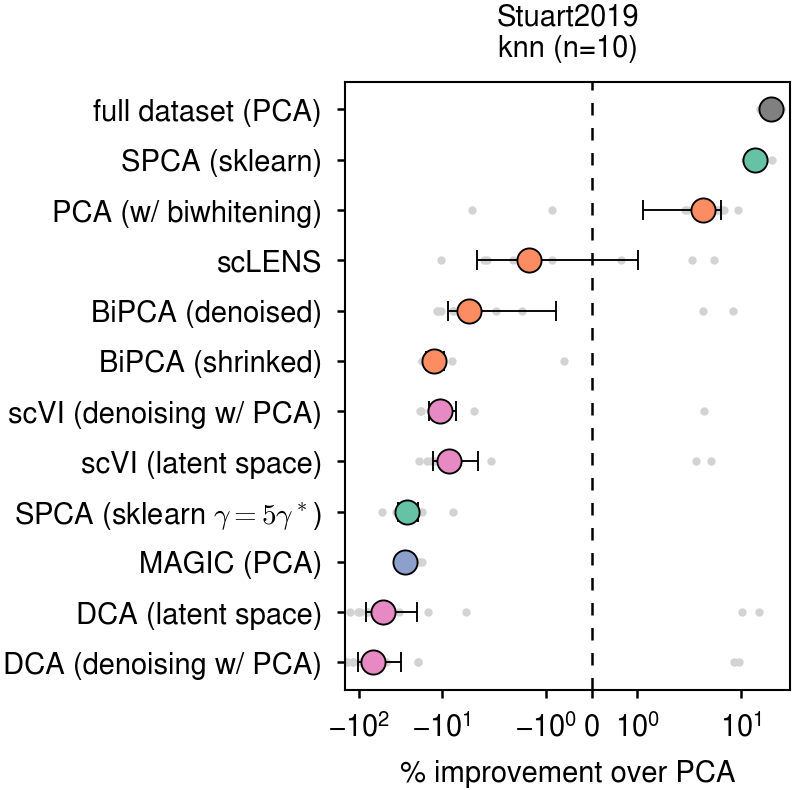

knn (n=25)


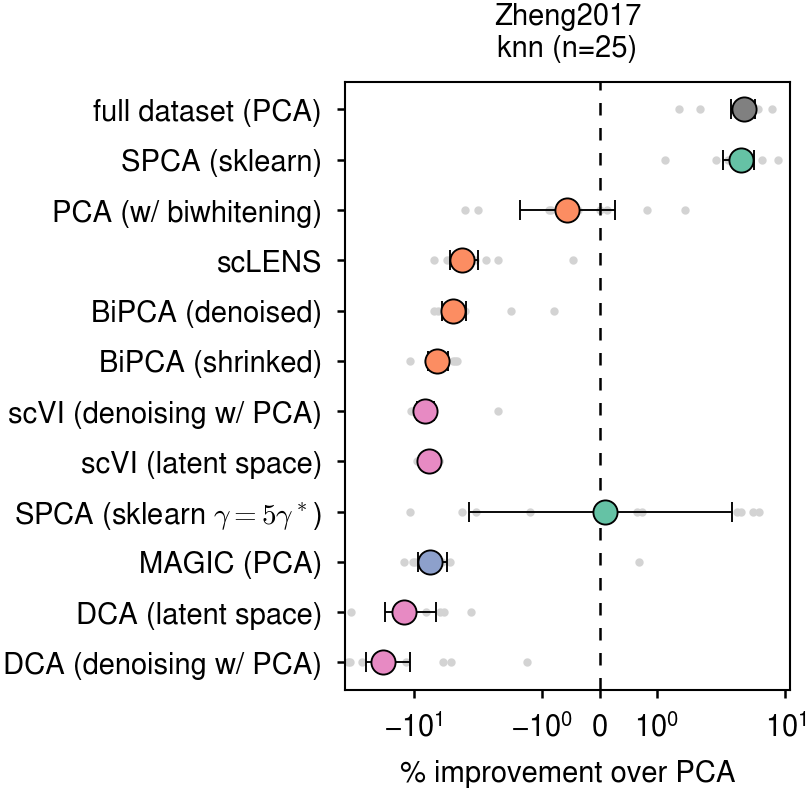

knn (n=25)


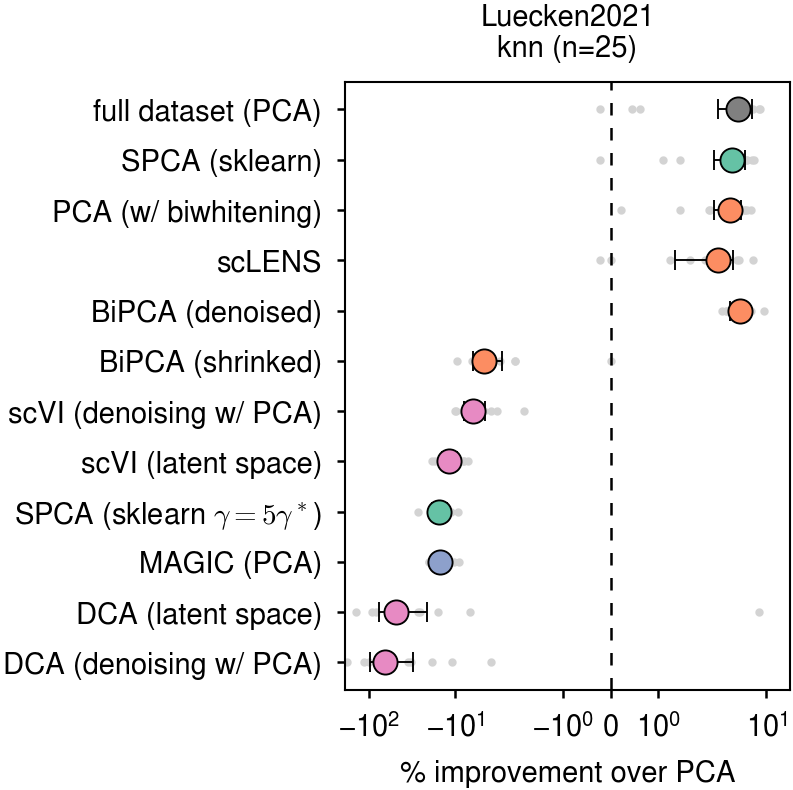

knn (n=25)


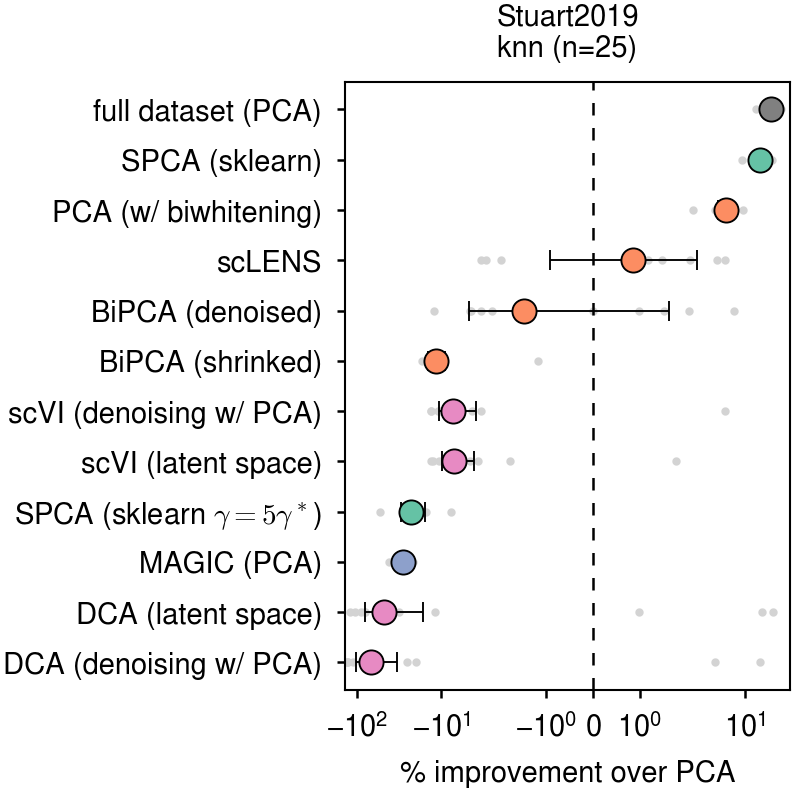

knn (n=40)


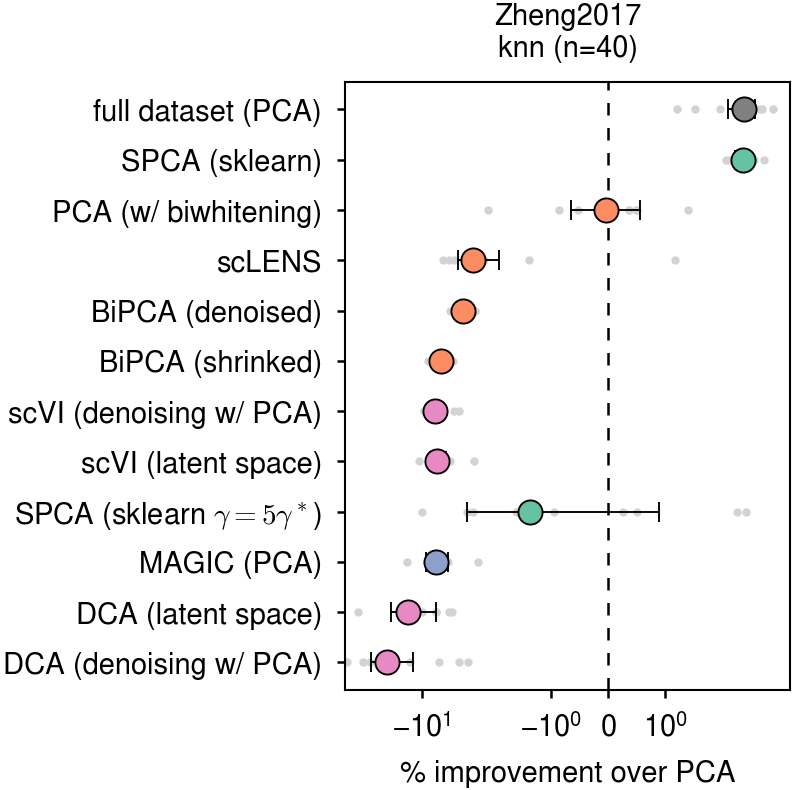

knn (n=40)


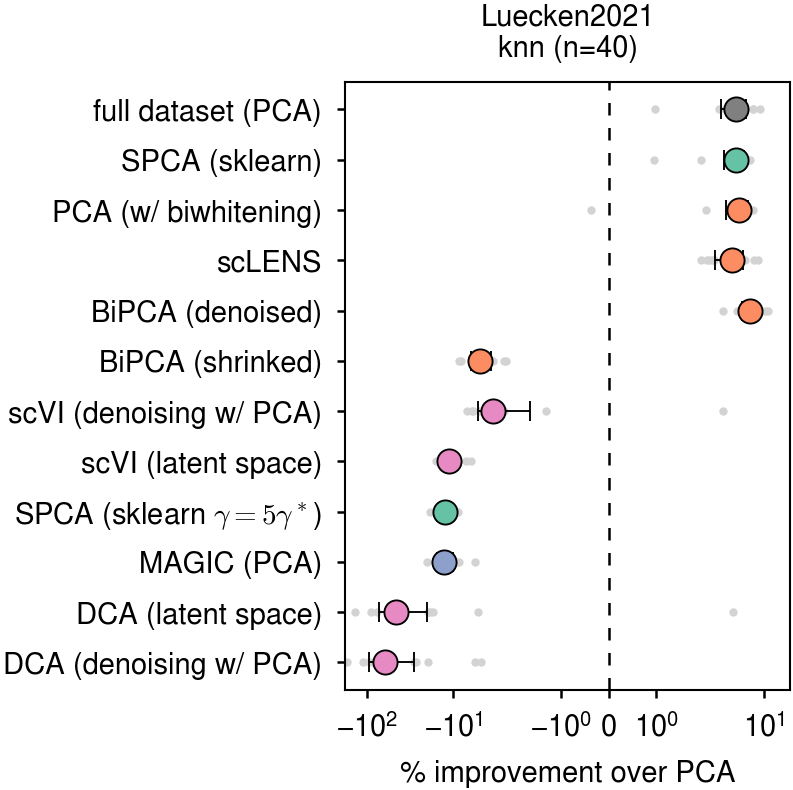

knn (n=40)


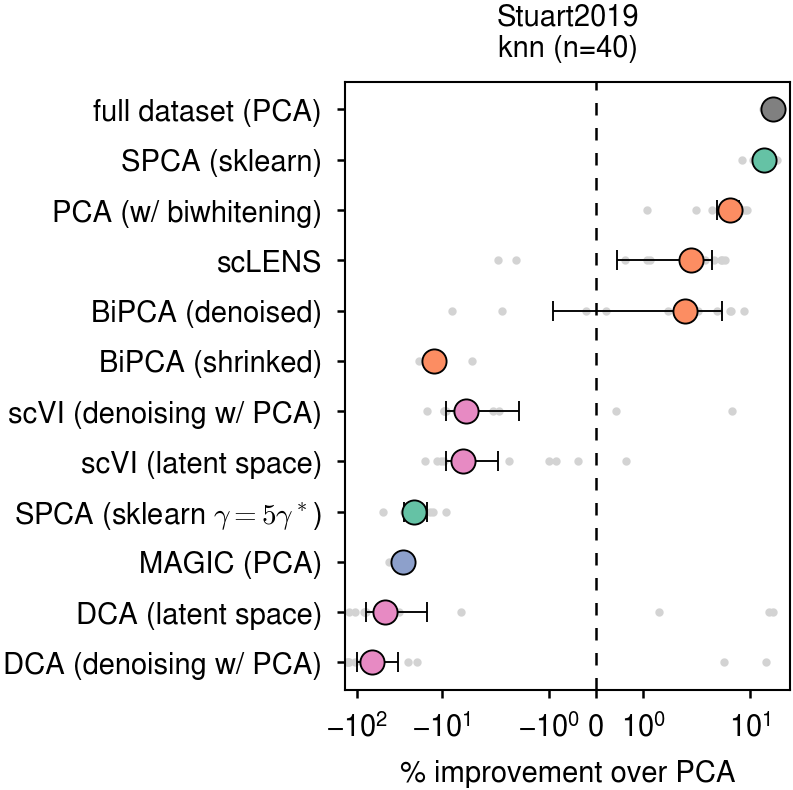

knn (umap) (n=10)


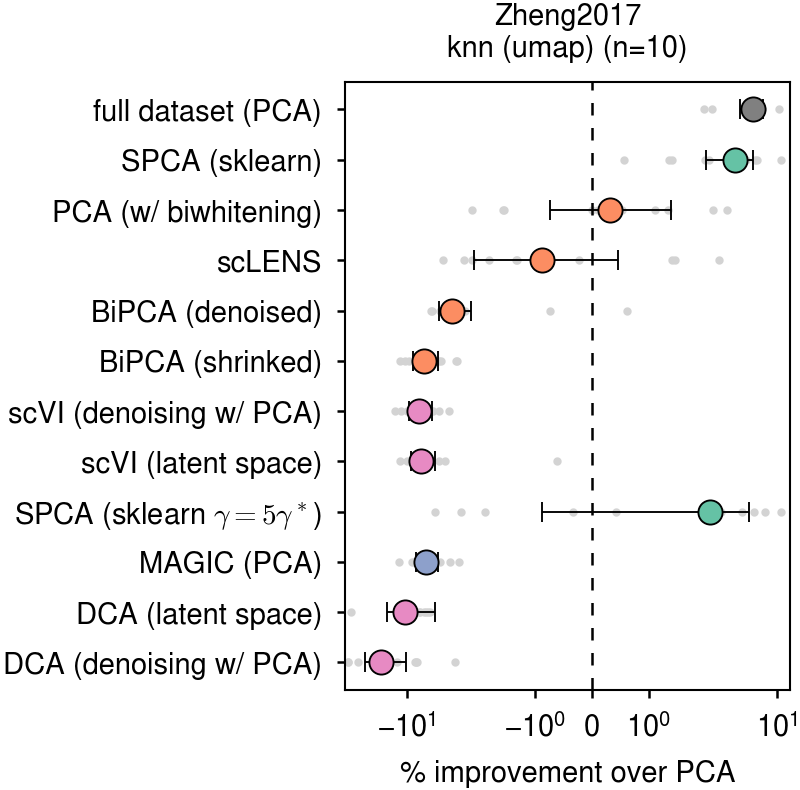

knn (umap) (n=10)


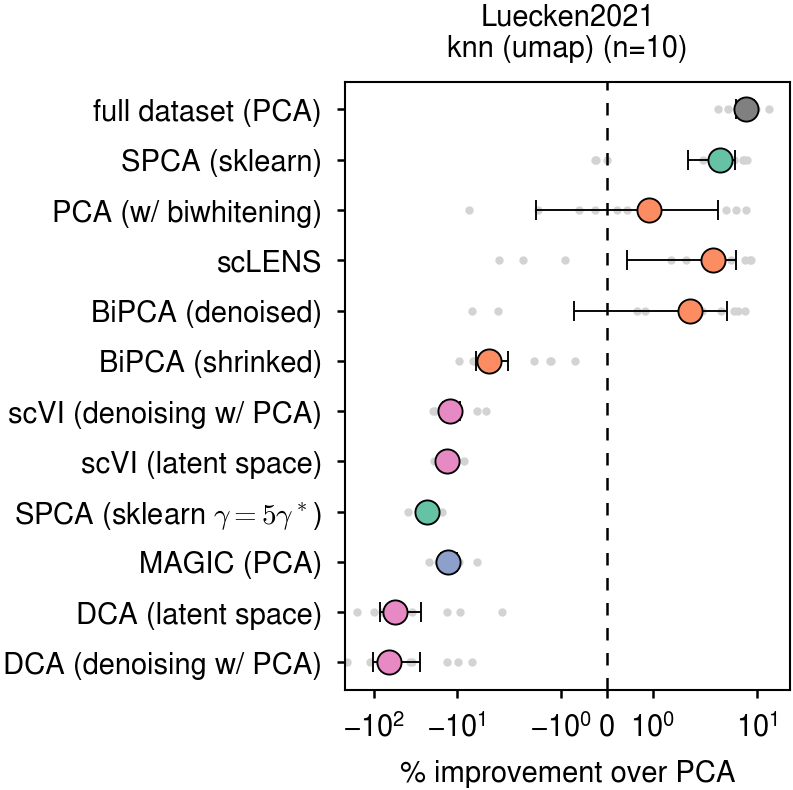

knn (umap) (n=10)


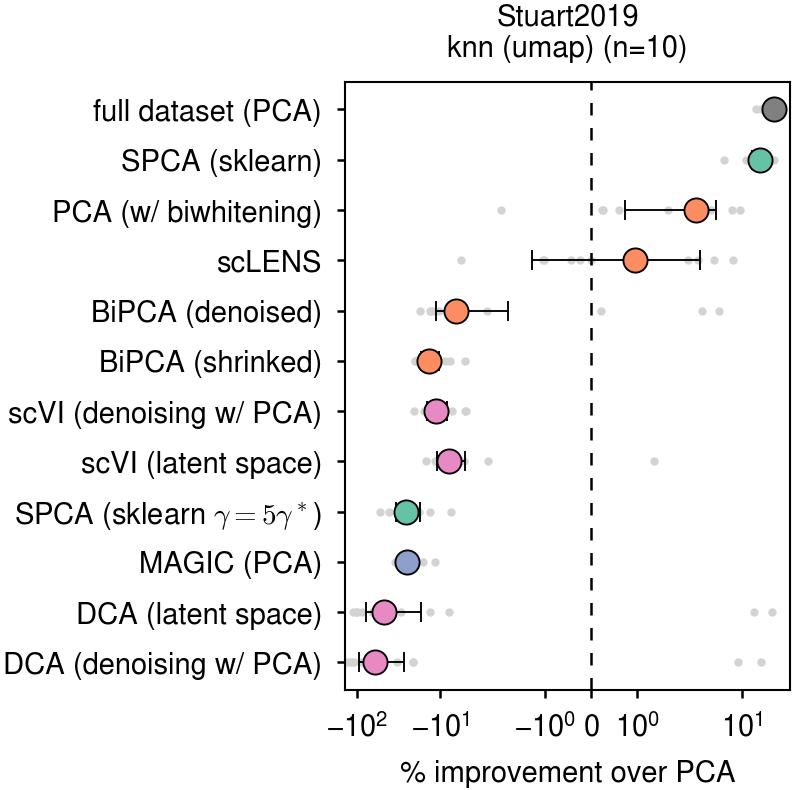

knn (umap) (n=25)


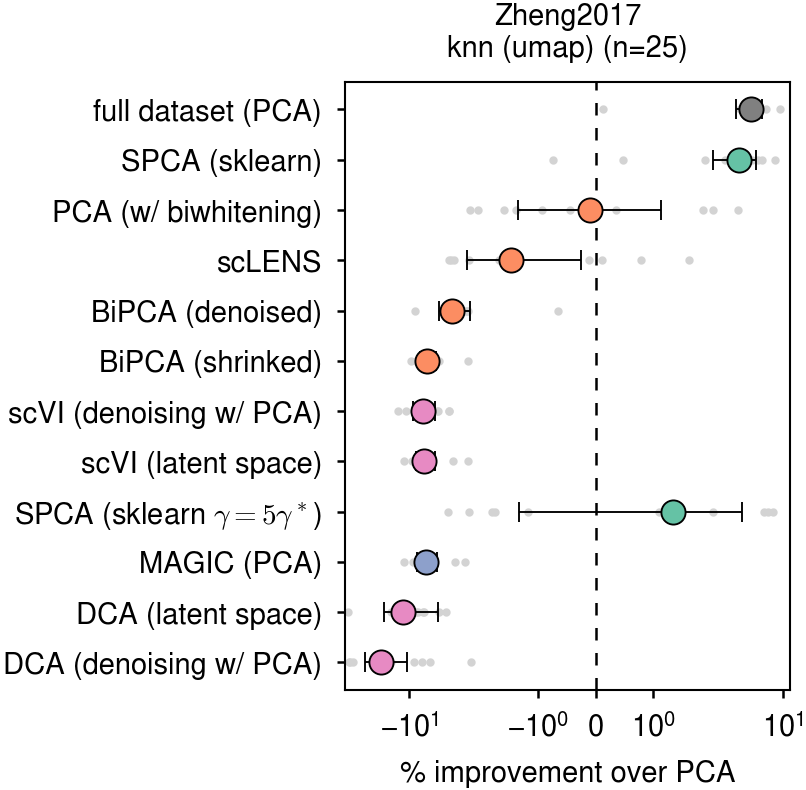

knn (umap) (n=25)


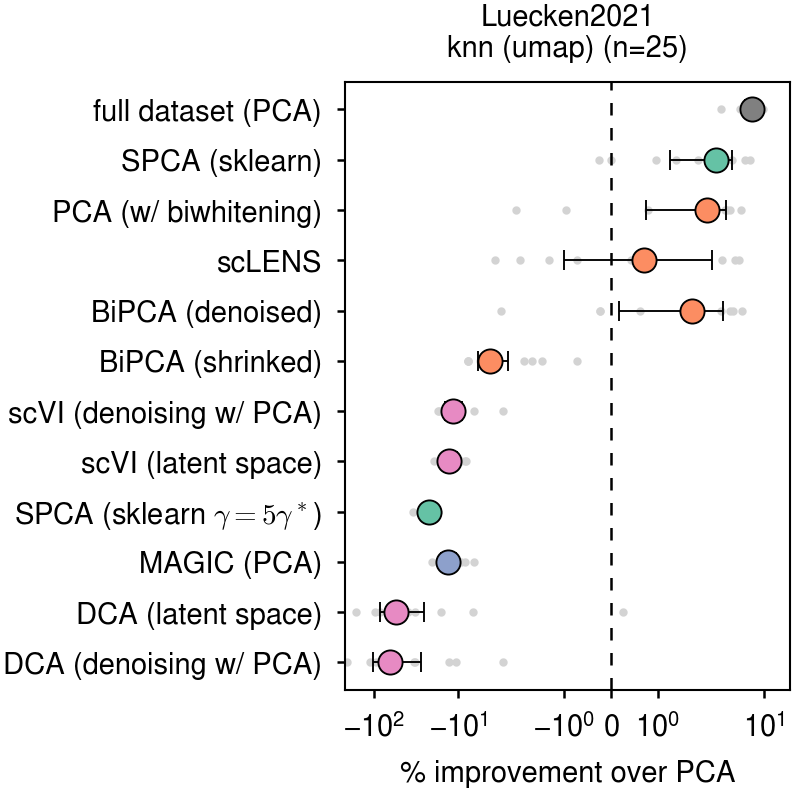

knn (umap) (n=25)


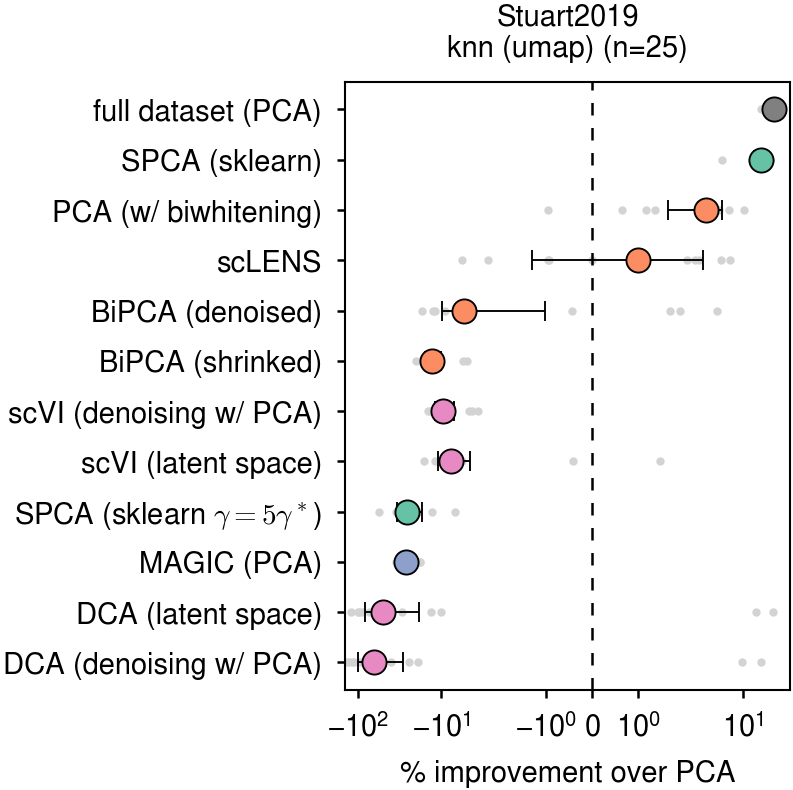

knn (umap) (n=40)


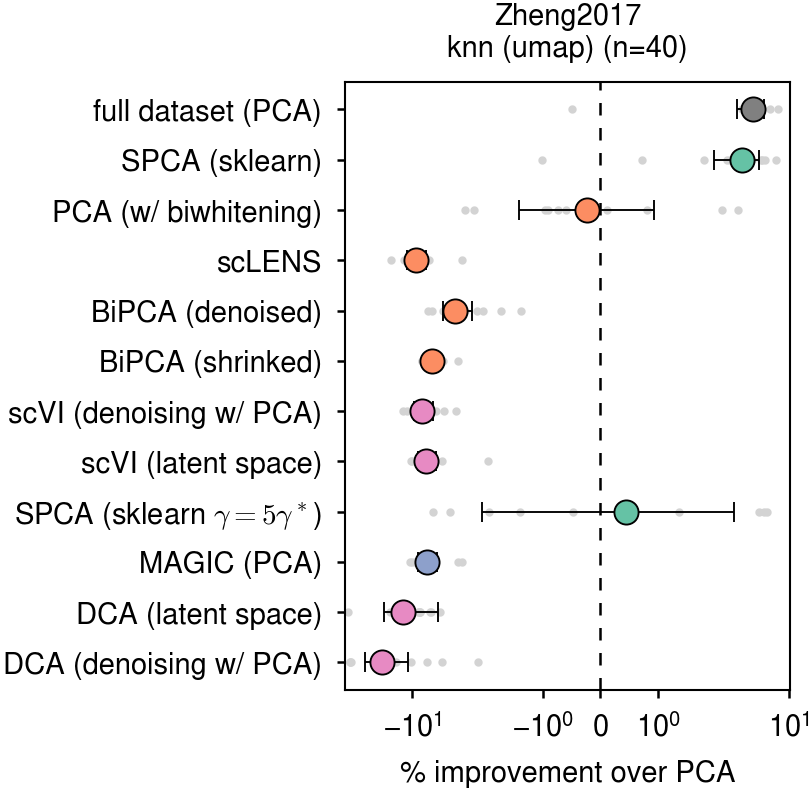

knn (umap) (n=40)


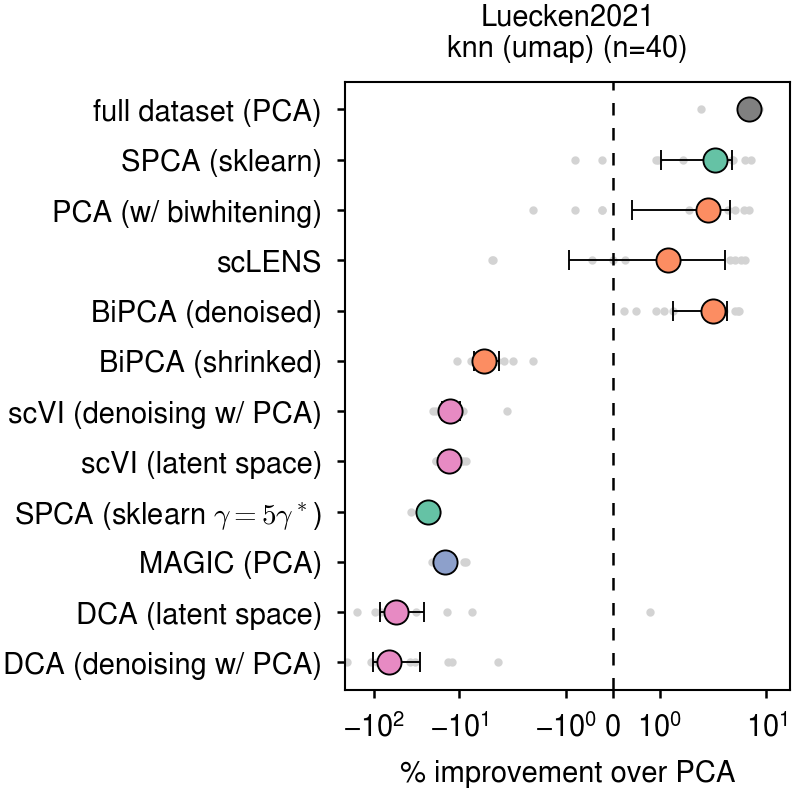

knn (umap) (n=40)


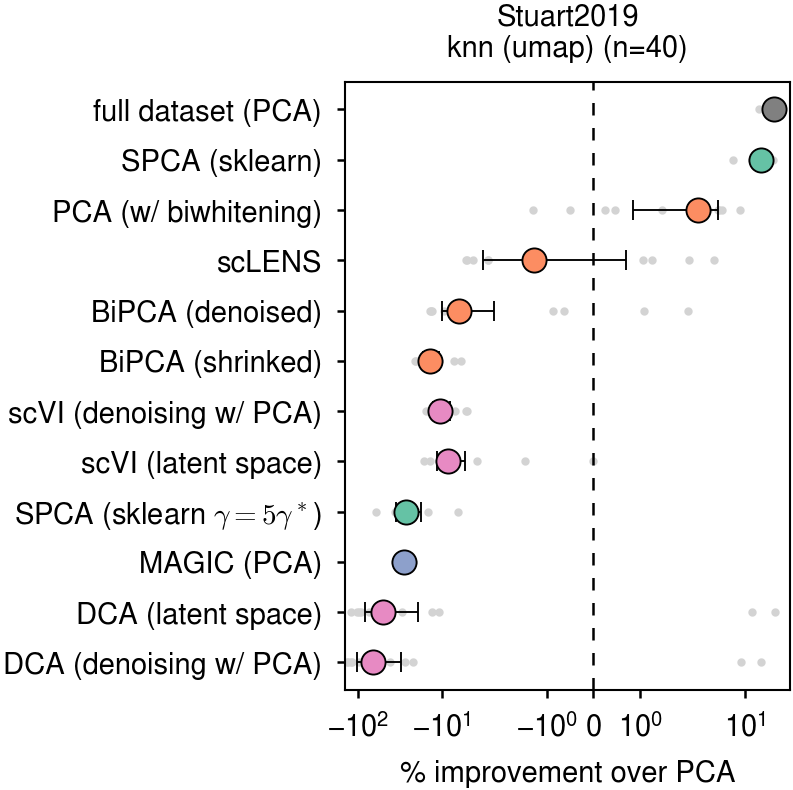

knn (distance) (n=10)


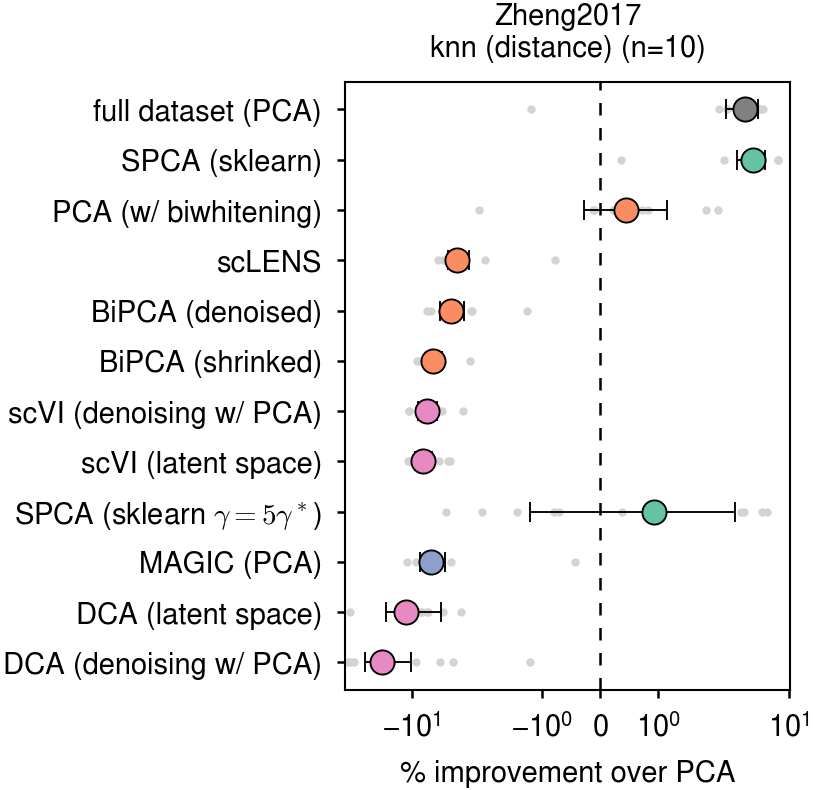

knn (distance) (n=10)


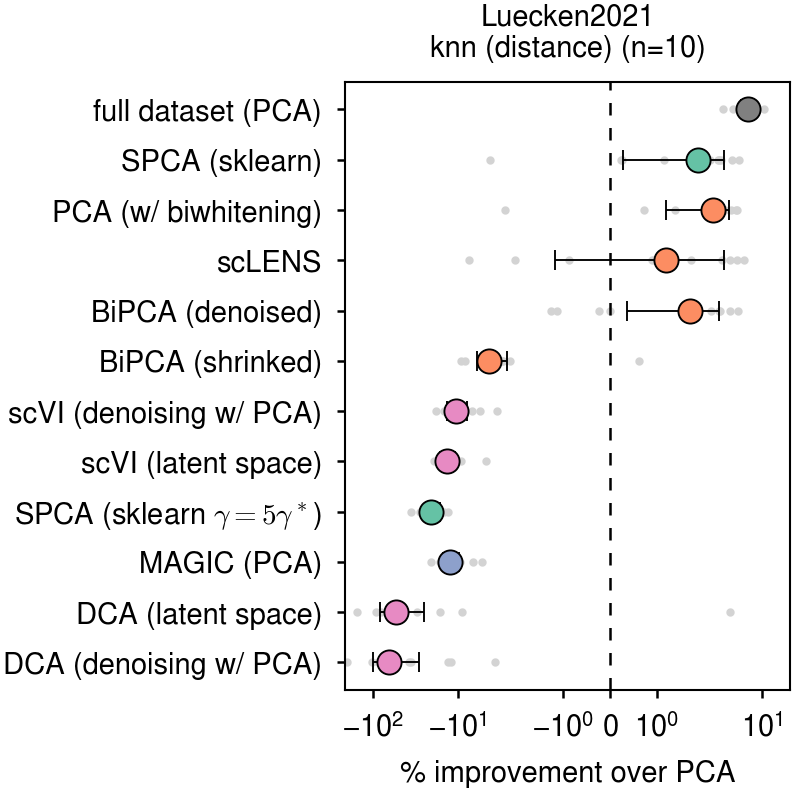

knn (distance) (n=10)


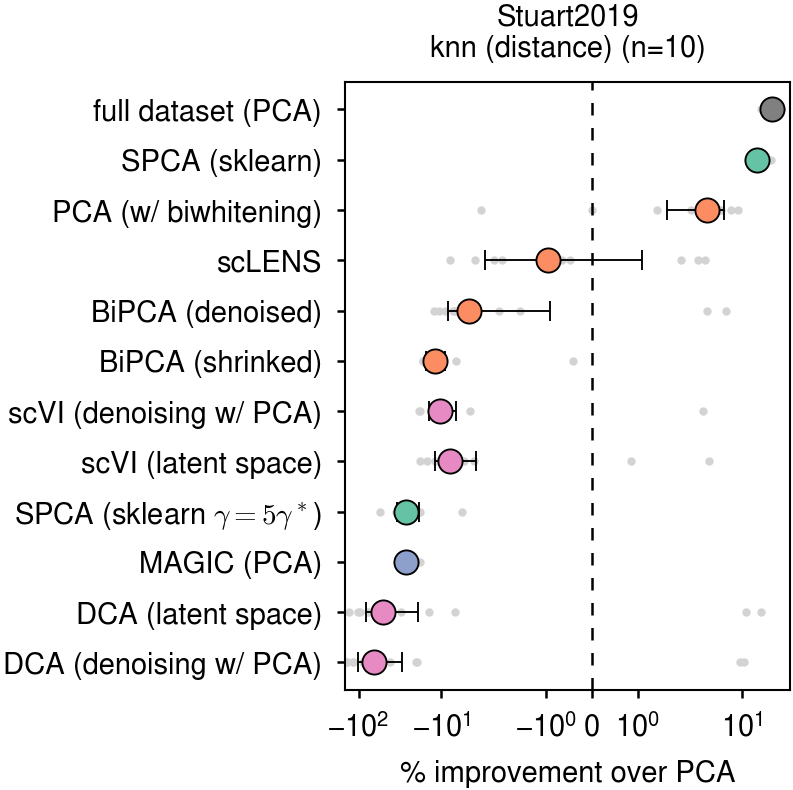

knn (distance) (n=25)


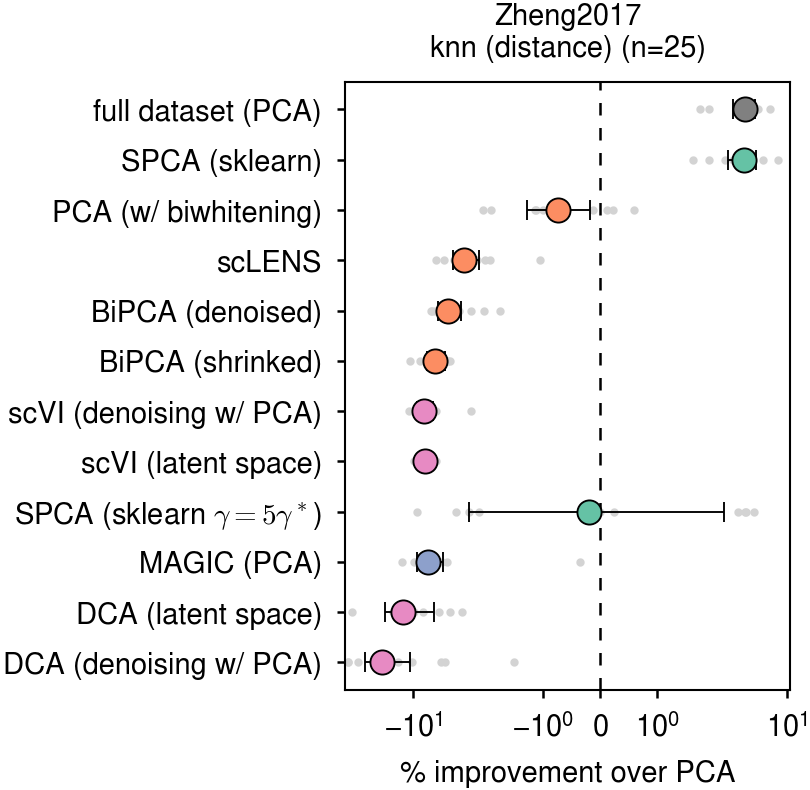

knn (distance) (n=25)


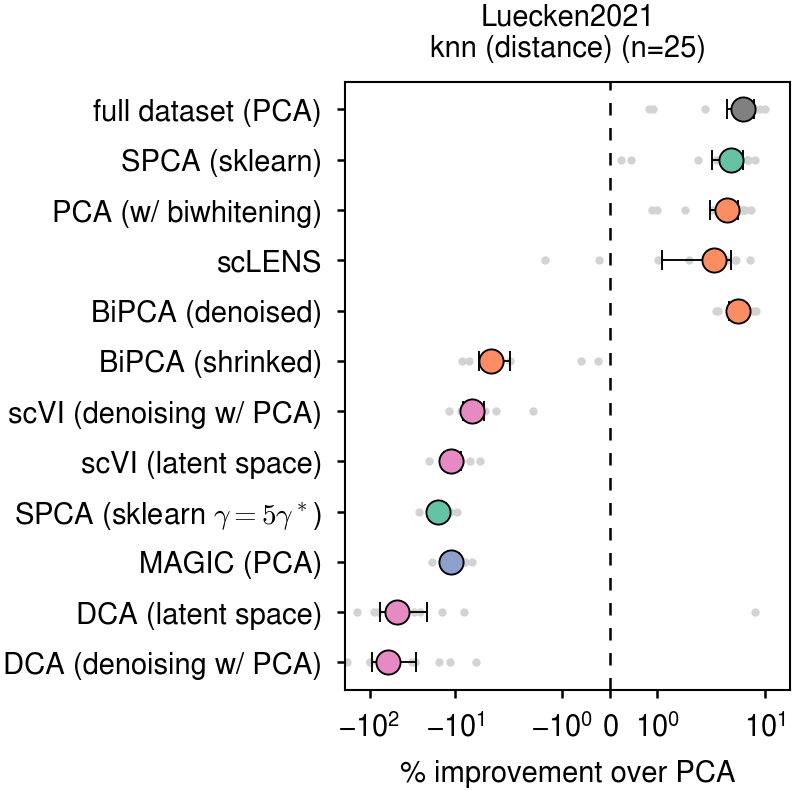

knn (distance) (n=25)


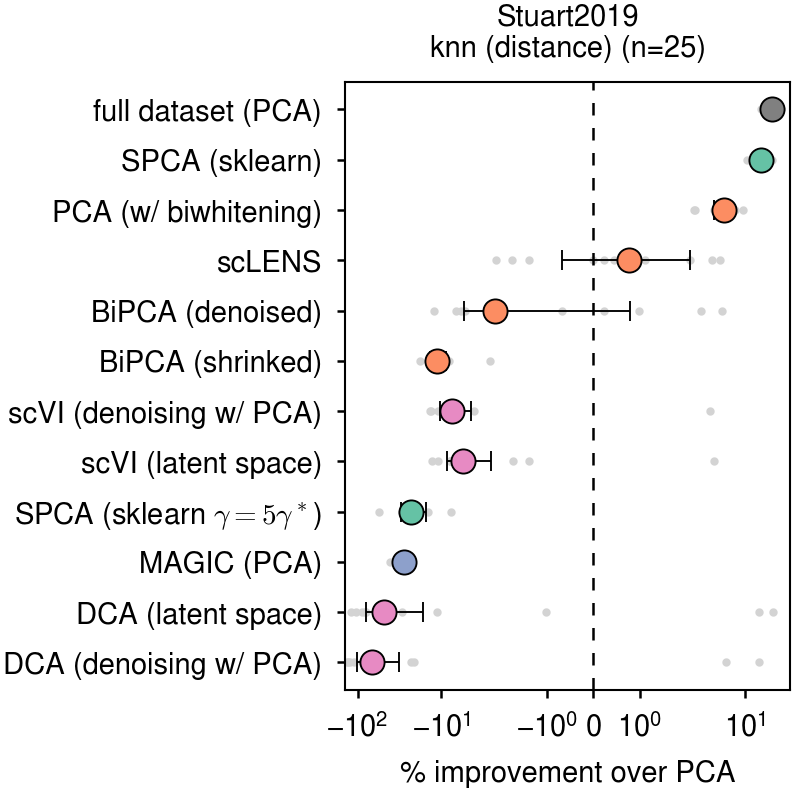

knn (distance) (n=40)


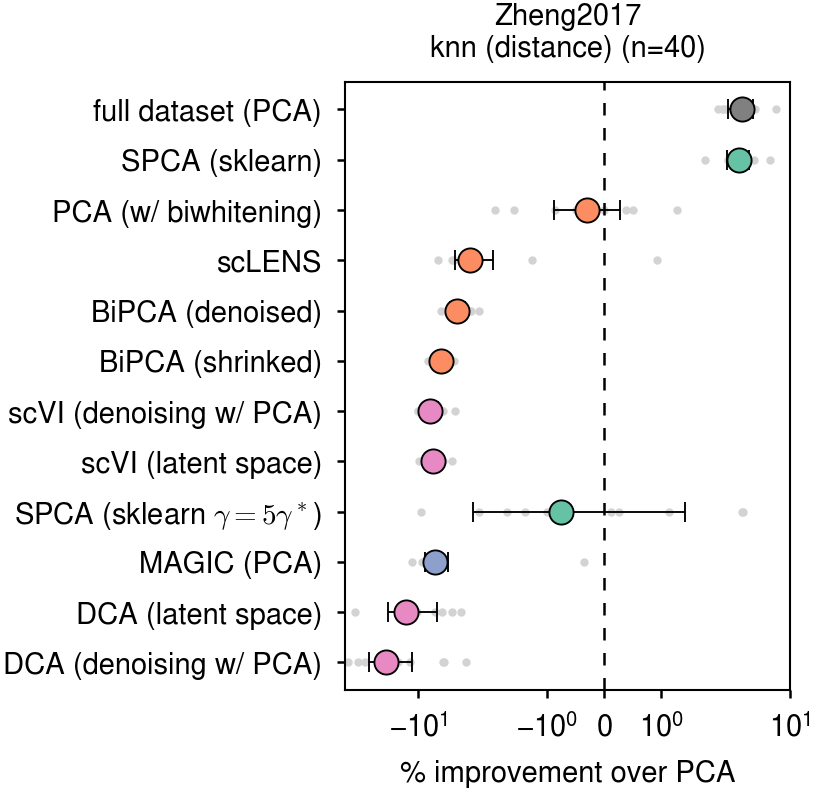

knn (distance) (n=40)


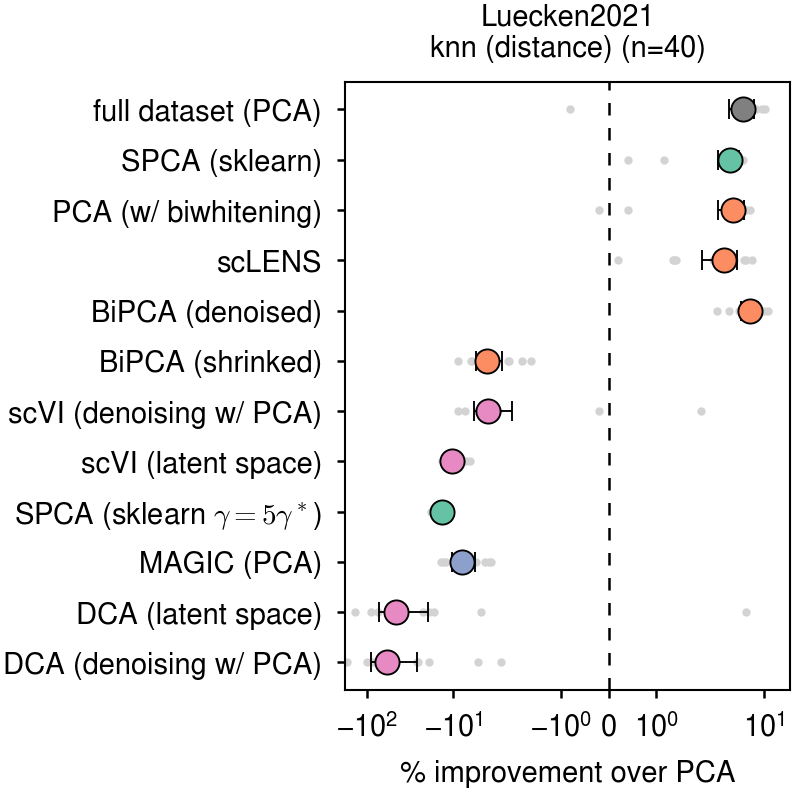

knn (distance) (n=40)


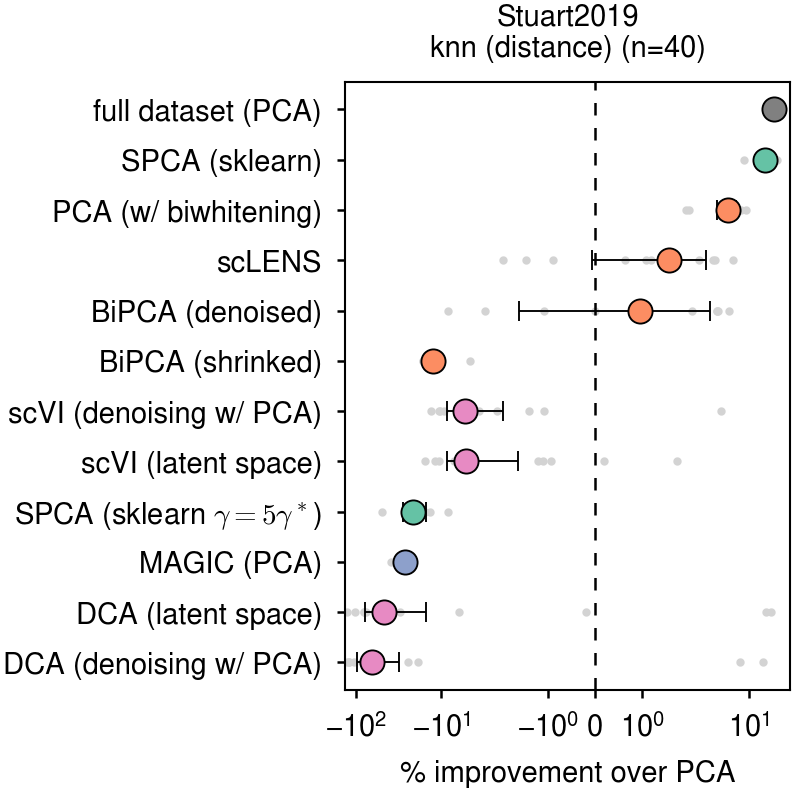

silhouette


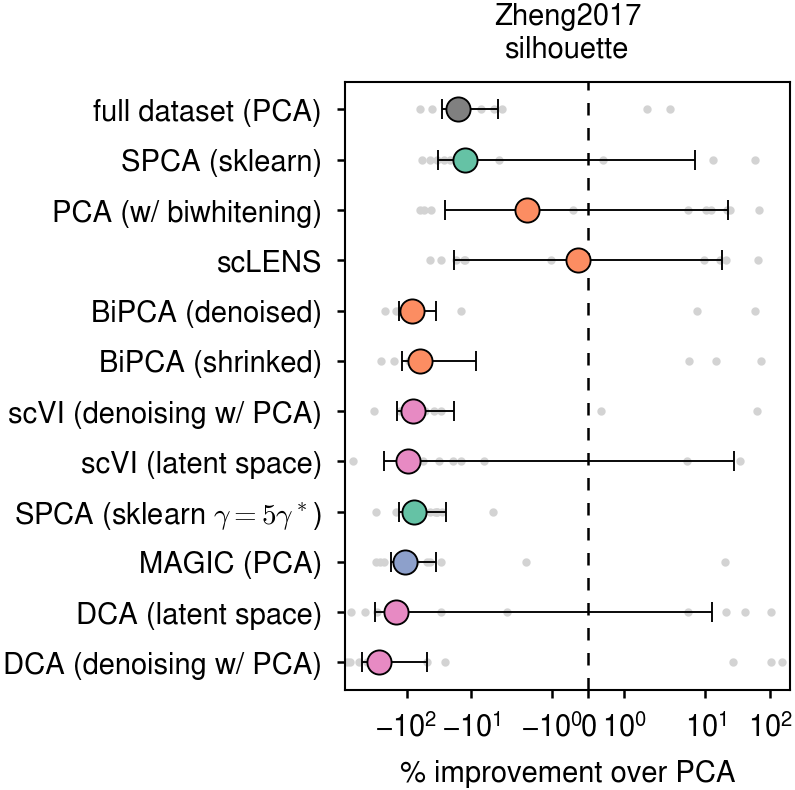

silhouette


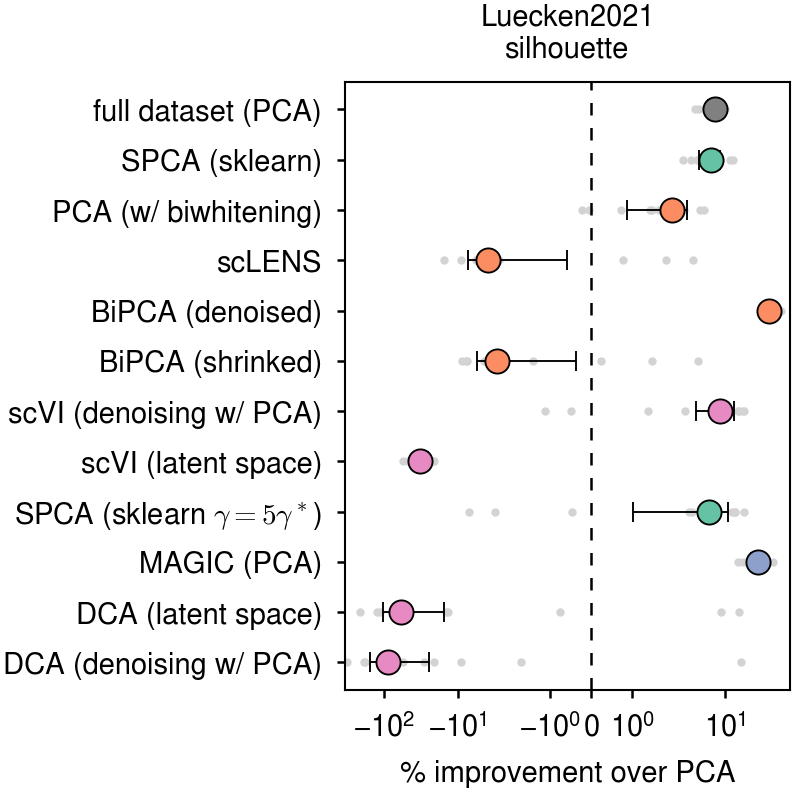

silhouette


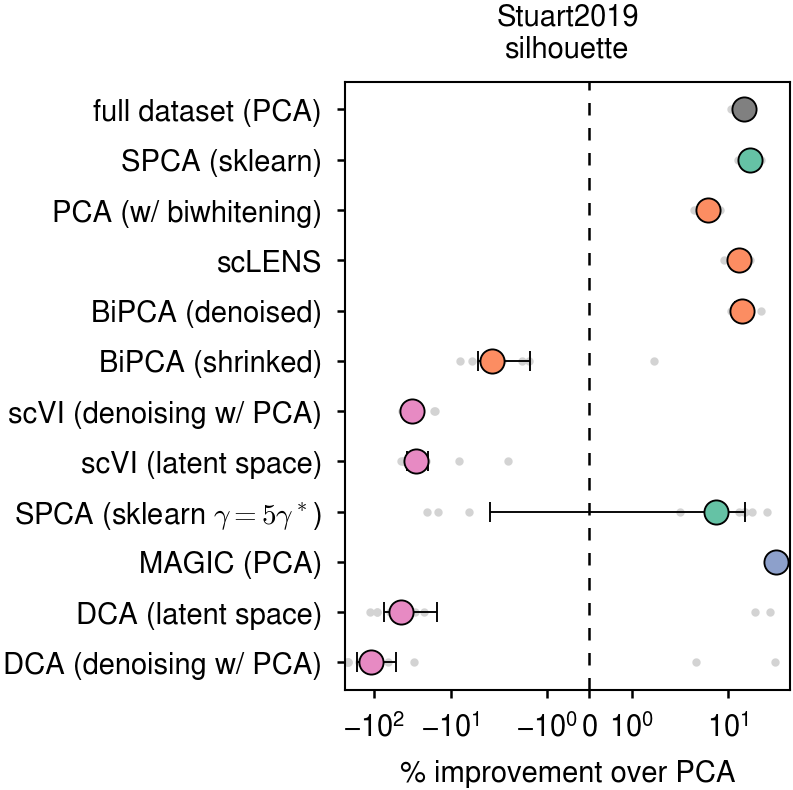

In [98]:
sorted_methods = rank_methods_global(res)#exclude=['Stuart2019\n(cite-seq)']

size = plt.rcParams['figure.figsize']
# Reverse map: method → category
method_to_category = {
    method: category
    for category, methods in classi.items()
    for method in methods
}


for name, _obs in res.items():
    datasets = list(_obs.keys())

    for dataset in datasets:
        values = []
        errors = []
        labels = []
        names = []
        method_colors = []

        for method in sorted_methods:
            if method == 'large_all_X_pca':
                continue
            if method not in res[name][dataset]:
                continue

            mean, std = res[name][dataset][method]
            values.append(mean)
            errors.append(2*std / np.sqrt(len(samples[name][dataset][method])))
            labels.append(method)
            names.append(good_names[method])

            category = method_to_category.get(method, 'large')
            method_colors.append(colors.get(category, 'black'))

        y = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(0.8*size[0], 1.1*size[1]))

        # 1. Plot individual trial values (aligned, no jitter)
        for i, method in enumerate(labels):
            trial_vals = samples[name][dataset][method]
            ax.plot(trial_vals, [y[i]] * len(trial_vals), 'o',
                    color='lightgray', alpha=1, markersize=1
                    , zorder=1)

        # 2. Plot mean values with error bars, colored by category
        
        print(name)
        for i in range(len(labels)):

            ax.errorbar(
                values[i],
                y[i],
                xerr=errors[i],
                fmt='o',
                color=method_colors[i],   # mean dot color
                ecolor='black',
                elinewidth=0.45,
                markeredgecolor='black',
                markeredgewidth=0.45,
                capsize=2.4,
                capthick=0.45,
                markersize=5.8,
                zorder=2
            )
        # Styling
        ax.set_yticks(y)
        ax.set_yticklabels(names, fontsize=7)
        ax.set_xscale('symlog')
        ax.axvline(0, color='black', linestyle=(0, (5, 5)), linewidth=0.6)
        ax.set_xlabel('% improvement over PCA', fontsize=7)
        
        _d = dataset.split('\n')[0]
        _n = name.replace(' ', '_')
        
        ax.set_title(f"{_d}\n{name}", fontsize=7)
        ax.tick_params(axis='both', which='major', length=2, width=0.6)
        plt.show()

        fig.savefig(f'figures/{_d.lower()}/celltype_{_n}_{flavor}_{ngenes}_{ntrials}_mean.pdf', dpi=300)

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for name, _obs in res.items():
    datasets = list(_obs.keys())

    for dataset in datasets:
        records = []

        for method in sorted_methods[dataset]:
            if method == 'large_all_X_pca':
                continue
            if method not in samples[name][dataset]:
                continue

            method_samples = samples[name][dataset][method]
            display_name = good_names.get(method, method)
            category = method_to_category.get(method, 'large')
            color = colors.get(category, 'black')

            for val in method_samples:
                records.append({
                    'Method': method,
                    'Good Name': display_name,
                    'Value': val,
                    'Category': category,
                    'Color': color
                })

        # Convert to DataFrame
        df = pd.DataFrame(records)

        # Set y-tick order (top to bottom) based on sorted_methods
        method_order = [good_names.get(m, m) for m in sorted_methods[dataset] if m != 'large_all_X_pca' and m in samples[name][dataset]]

        fig, ax = plt.subplots(figsize=(1.1 * size[0], 1.2 * size[1]))

        # Boxplot
        sns.boxplot(
            data=df,
            x='Value',
            y='Good Name',
            order=method_order,
            hue='Category',
            palette=colors,
            ax=ax,
            linewidth=0.6,
            width=0.6,
            fliersize=0.5
        )

        # Optional: overlay individual points
        sns.stripplot(
            data=df,
            x='Value',
            y='Good Name',
            order=method_order,
            color='lightgray',
            size=1.2,
            jitter=False,
            alpha=1,
            ax=ax,
            zorder=1
        )

        # Style
        ax.set_xscale('symlog')
        ax.axvline(0, color='black', linestyle=(0, (5, 5)), linewidth=0.6)
        ax.set_xlabel('% improvement over PCA', fontsize=7)
        ax.set_title(f"{dataset}", fontsize=7)
        ax.tick_params(axis='both', which='major', length=2, width=0.6)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

        # Remove duplicate legend entries
        handles, labels_ = ax.get_legend_handles_labels()
        unique = dict(zip(labels_, handles))
        ax.legend('', frameon = False)

        plt.tight_layout()
        plt.show()

        _d = dataset.split('\n')[0].lower()
        _n = name.replace(' ', '_')
        fig.savefig(f'figures/{_d}/celltype_{_n}_boxplot.pdf', dpi=300)


TypeError: list indices must be integers or slices, not str